In [1]:
# cool libraries
import torch
import imageio as iio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
class MyDataset(Dataset):
    def __init__(self, db_path, transform=None, target_transform=None):
        self.db_path = db_path
        self.transform = transform
        self.target_transform = target_transform
        self.entries = self.create_list() # [(image, label)]

    def create_list(self):
        folders = os.listdir(self.db_path)
        entries = []
        for i in range(len(folders)):
            image_paths = os.listdir(os.path.join(self.db_path, folders[i]))
            for path in image_paths:
              img_path = os.path.join(self.db_path, folders[i], path)
              image = iio.imread(img_path)
              entries.append((image, i))
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        image = self.entries[idx][0]
        label = self.entries[idx][1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
def process_data(batch_sz, shuffle=True, random_seed=2000):

  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize([224,224]),
      transforms.ToTensor()
  ])

  dataset = MyDataset("dataset", transform)

  num = len(dataset)
  indices = list(range(num))
  split = int(np.floor(0.2 * num)) # 20% test split

  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, test_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, sampler=test_sampler, pin_memory=True)

  return train_loader, test_loader

In [4]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_loader, test_loader = process_data(batch_sz)

/tmp/ipykernel_2460/1934560902.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(img_path)


In [5]:
def label_str(x):
  labels = ["metal", "misc", "plastic", "glass", "paper", "cardboard"]
  return(labels[x])

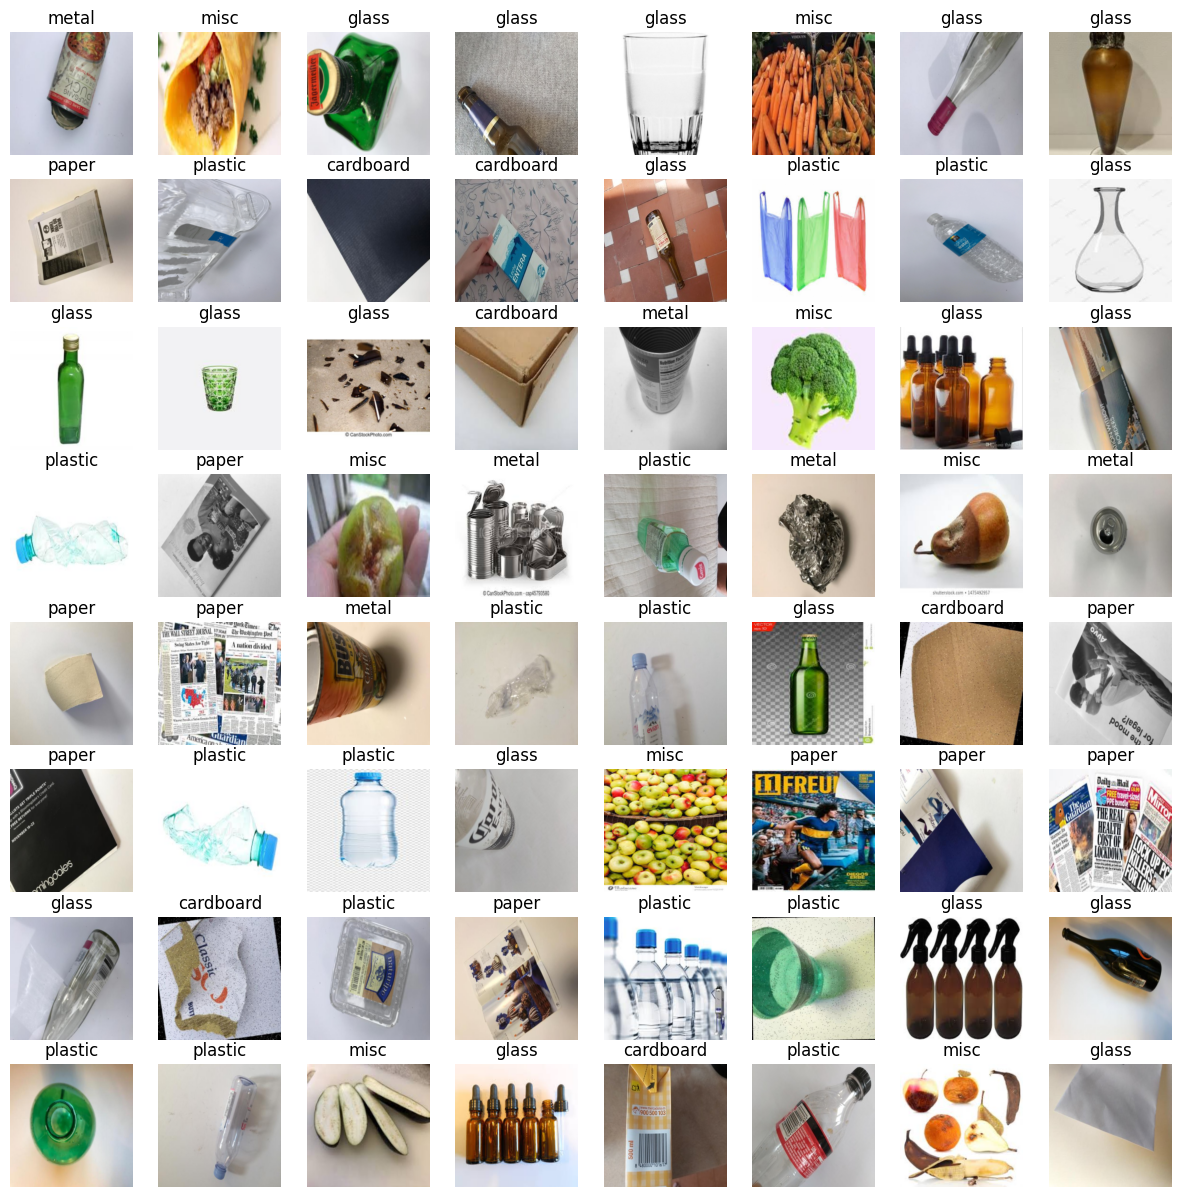

In [6]:
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
  plt.imshow(img)
  plt.title(label_str(labels[i].item()))
  plt.axis("off")

In [7]:
def train(net, num_epochs, lr, momentum):

  # Specify a folder under run for tensorboard data for the training

  writer = SummaryWriter("runs/lr_1")
  device = torch.device("cuda")

  net = net.to(device)
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
  lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
  train_losses = []

  for i in range(num_epochs):

      loss_total = 0
      acc_train = 0
      total_train = 0

      for ii, batch in enumerate(train_loader):

          data = batch[0]
          label = batch[1]
          optimizer.zero_grad()
          data, label = data.to(device), label.to(device)
          logits = net(data)
          if isinstance(logits, tuple):  # If the model returns a tuple
            logits = logits[0]
          else:  # If the model returns a single tensor
            logits = logits
          loss = F.cross_entropy(logits, label)
          loss_total += loss.item()
          loss.backward()
          optimizer.step()
          out = torch.argmax(logits, dim=1)
          acc_train += torch.sum(out == label)
          total_train += logits.shape[0]

      train_loss_avg = loss_total / ii
      train_acc_avg = acc_train.item() / total_train
      train_losses.append(train_loss_avg)
      lr_scheduler.step()

      print(f"Epoch {i}: Training Loss: {train_loss_avg}")
      print(f"Epoch {i}: Training Accuracy: {train_acc_avg}")

      writer.add_scalar('Loss/train', train_loss_avg, i)
      writer.add_scalar('Accuracy/train', train_acc_avg, i)

  print(f"Final Training Loss: {train_loss_avg}")
  print(f"Final Training Accuracy: {train_acc_avg}")

  # Plot the data
  plt.plot(train_losses, label='Training Set')

  # Add legend
  plt.legend()

  # Add title and labels
  plt.title('Loss vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the graph
  plt.show()

  return train_losses


In [8]:
net = models.resnet50(pretrained=True)
net.fc = nn.Linear(in_features=2048, out_features=6, bias=True)

/home/mambo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mambo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/mambo/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 0: Training Loss: 0.7514517270028591
Epoch 0: Training Accuracy: 0.7469637883008357
Epoch 1: Training Loss: 0.3029720061059509
Epoch 1: Training Accuracy: 0.8934818941504178
Epoch 2: Training Loss: 0.17946519452546325
Epoch 2: Training Accuracy: 0.9387186629526463
Epoch 3: Training Loss: 0.1021103567177696
Epoch 3: Training Accuracy: 0.966908077994429
Epoch 4: Training Loss: 0.06987887310595917
Epoch 4: Training Accuracy: 0.977158774373259
Final Training Loss: 0.06987887310595917
Final Training Accuracy: 0.977158774373259


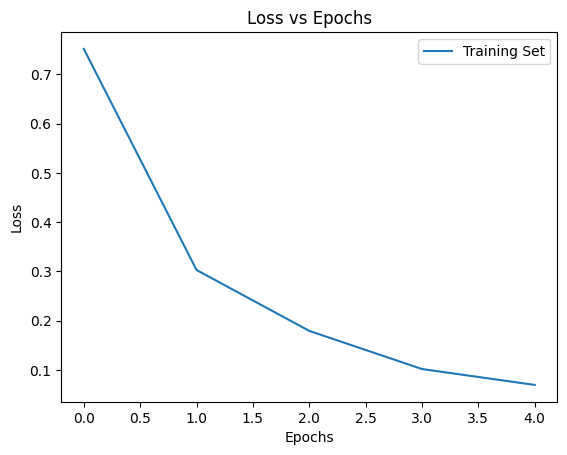

[0.7514517270028591,
 0.3029720061059509,
 0.17946519452546325,
 0.1021103567177696,
 0.06987887310595917]

In [9]:
train(net, 5, 2e-2, 0.9)

In [10]:
def test(net):

  device = torch.device('cuda:0')
  net = net.to(device)
  net.eval()

  predictions = []
  true = []
  
  with torch.no_grad():

    total_loss = 0
    acc_test = 0
    total_test = 0
    
    for batch in test_loader:
      data = batch[0]
      label = batch[1]
      data, label = data.to(device), label.to(device)
      logits = net(data)
      if isinstance(logits, tuple):  # If the model returns a tuple
        logits = logits[0]
      else:  # If the model returns a single tensor
        logits = logits
      
      predictions.extend(torch.argmax(logits, dim=1).cpu().detach().numpy())
      true.extend(label.cpu().detach().numpy())
      
      loss = F.cross_entropy(logits, label)
      total_loss += loss.item()
      out = torch.argmax(logits, dim=1)
      acc_test += torch.sum(out == label)
      total_test += logits.shape[0]

  # Compute the confusion matrix for training data
  ax = plt.subplot()
  cm = confusion_matrix(true, predictions)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

  # Set labels, title, and tick parameters
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels([label_str(0), label_str(1), label_str(2), label_str(3), label_str(4), label_str(5)])
  ax.yaxis.set_ticklabels([label_str(0), label_str(1), label_str(2), label_str(3), label_str(4), label_str(5)], rotation=0, ha='right')

  # Rotate the tick labels for better readability
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

  # Display the plot
  plt.tight_layout()
  plt.show()
  print(f"Testing Loss: {total_loss/len(test_loader)}")
  print(f"Testing Accuracy: {acc_test/total_test}")

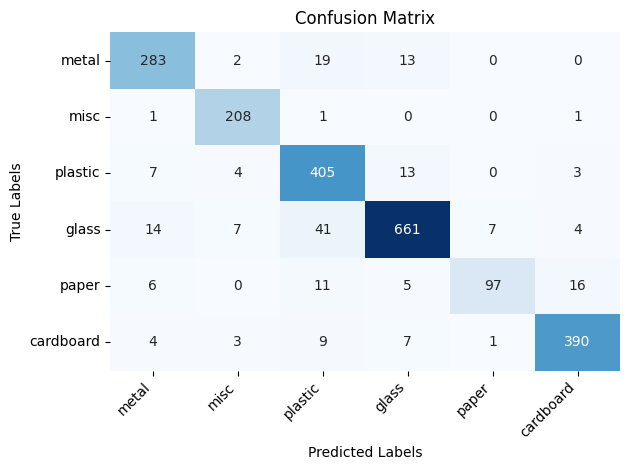

Testing Loss: 0.33223084534155434
Testing Accuracy: 0.911279559135437


In [11]:
test(net)

In [12]:
torch.save(net, "../model/trash.pth")